<a href="https://colab.research.google.com/github/vikasvr1997/fmml2021/blob/main/Lab_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FMML Lab 16: Probabilistic ML models

Topics:
1. Convolutional Operation
2. CNN and Using Learnt Representations
3. CNN Visualization
4. Autoencoders

## 1. Convolutional Operations

Central to Convolutional Neural Networks (CNN), a convolution operation is a linear operation which involves element-wise multiplication between a small filter (say, a matrix of integers) and filter-sized patch from the image. We move this filter across the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image. 

Let's look at the convolution formula:

Convolution between image $f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>


Image reference: [Streaming Architecture for Large-Scale Quantized Neural Networks on an FPGA-Based Dataflow Platform](https://www.researchgate.net/publication/318849314_Streaming_Architecture_for_Large-Scale_Quantized_Neural_Networks_on_an_FPGA-Based_Dataflow_Platform/figures?lo=1)

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

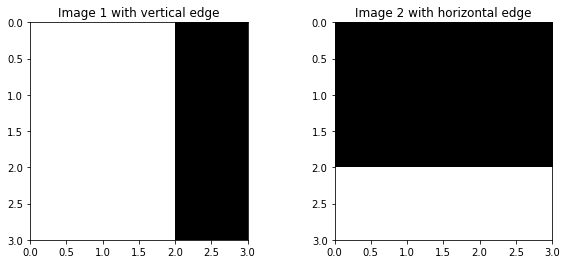

In [2]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0],
                   [1,1,0],
                   [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0],
                   [0,0,0],
                   [1,1,1]])

# print(image1*255)
# Let's plot the images
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
# plt.ylim(0, 3)
ax.set_title('Image 1 with vertical edge')

ax = fig.add_subplot(1,2,2)
ax.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
ax.set_title('Image 2 with horizontal edge')
plt.show()

Let's create a 3x3 vertical edge filter. We will 'convolve' this filter over the images to detect vertical edge. As the image is same size as of filter, this is simple element-wise multiplication and summing up the result into single value.

In [3]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

In [4]:
# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image.
Now, let's create a horizontal edge filter and apply it to both the above images.

In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


As expected, the horizontal edge is detected in second image with this filter. 

Now, we will take a bigger image (5 x 5) and see how a convolution operation works by sliding a filter left to right and top to bottom to obtain an output map from image. Let's define a function ***apply_filter()*** for this.

In [6]:
def apply_filter(img, filter):
  height, width = img.shape
  filter_size = filter.shape

  output = np.empty(0)

  # Move the filter over entire image and store the result in output
  for i in range(0, height - filter_size[1] + 1):
    for j in range(0, width - filter_size[0] + 1):
      # Matrix multiplication for a single patch of image and filter
      output = np.append(output, np.sum(np.multiply(img[i:i+filter_size[0], j:j+filter_size[1]], filter)))
  
  # Calculate the output shape of the resultant image
  output_shape = (height - (filter_size[1]-1)), (width - (filter_size[0]-1))

  # Return the reshaped image
  return output.reshape(output_shape)

Plotting function

In [7]:
def plot_images(images, titles, tick_params=True):
  n = len(images)
  fig = plt.figure(figsize=(10,4))
  for i in range(n):
    ax = fig.add_subplot(1,n,i+1)
    if len(images[i].shape) == 2:
      ax.imshow(images[i], cmap='gray', 
                extent=(0,images[i].shape[1], images[i].shape[0], 0))
    else:
      ax.imshow(images[i])
    ax.set_title(titles[i])
    if not tick_params:
      plt.tick_params(axis='both', labelbottom=False, bottom=False, 
                labelleft=False, left=False)
  plt.show()

In [8]:
# 2D image
img = np.array([[20,20,0,0,0],
                [20,20,0,0,0],
                [20,20,0,0,0],
                [20,20,0,0,0],
                [20,20,0,0,0]])

# Vertical edge filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])


output = apply_filter(img, filter)
print(output) # Note the shape of output image!

[[60. 60.  0.]
 [60. 60.  0.]
 [60. 60.  0.]]


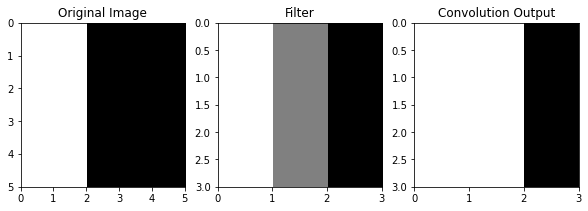

In [9]:
# Let's plot the above image with results
images = []
titles = []

images.append(img)
titles.append('Original Image')

images.append(filter)
titles.append('Filter')

images.append(output)
titles.append('Convolution Output')

plot_images(images, titles)

As, you can see, horizontal edge is detected in the output.

Now, we will see the effect of applying this filter on a grayscale image. Again, for this, we need to 'convolve' the filter over the entire image.
We will use the same filter and function defined earlier.

In [10]:
# Get the sample image
!curl -L -o 'lotus.jpg' 'https://drive.google.com/uc?export=download&id=1gQSQlrUws22KLRUacXwvN1G8FtIyhfGt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2815  100  2815    0     0   2762      0  0:00:01  0:00:01 --:--:--  2762


Original image size:  (99, 100)
Output image size:  (97, 98)


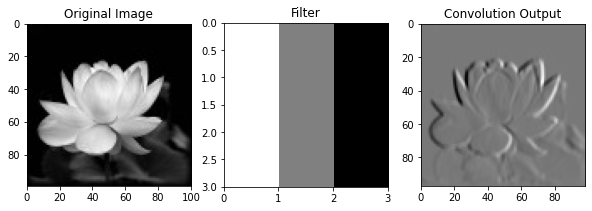

In [11]:
# Read the image with opencv, 0 stands for 'grayscale'
image = cv2.imread('lotus.jpg', 0)
print('Original image size: ', image.shape)

# Saving images for plots
images = []
titles = []

images.append(image)
titles.append('Original Image')

# Vertical edge filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

images.append(filter)
titles.append('Filter')

# Apply this filter to image
output = apply_filter(image, filter)

print('Output image size: ', output.shape)

images.append(output)
titles.append('Convolution Output')

# Let's plot the images
plot_images(images, titles)

### Exercise
1. Try padding in convolution on lotus.jpg and show results
2. Try stride  in convolution on lotus.jpg and show results

## 2. CNN and Using Learnt Representations

Now lets implement a CNN in pytorch and use the learnt representations for image classification of MNIST dataset.

<img src='https://miro.medium.com/max/1872/1*SGPGG7oeSvVlV5sOSQ2iZw.png' />

Image reference: https://miro.medium.com/max/1872/1*SGPGG7oeSvVlV5sOSQ2iZw.png

We will be implementing a CNN model which can predict the digit, given a grayscale image. The architecture of model is given in the above image.

**We will do the following steps in order:**
1.   Load and visualize MNIST training and test datasets using torchvision
2.   Define the CNN model
3.   Define a loss function and optimizer
4.   Train the network on the training data
5.   Evaluate the network on the test data

In [12]:
# Import packages
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np


In [13]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#### Load MNIST data
We will use the [MNIST dataset](https://pytorch.org/vision/stable/datasets.html#mnist) from torchvision Pytorch and setup the train and test dataloaders.

In [15]:
batch_size_train = 128
batch_size_test = 128

# Images in torchvision datasets are PIL Images in range [0,1] so we need
# 'ToTensor' transform to convert them into tensors
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Understand the dataset
Let us now visualize the dataset in terms of number of samples, classes etc.

In [16]:
print('Training data shape : ', train_data.data.shape, train_data.targets.shape)
print('Testing data shape : ', test_data.data.shape, test_data.targets.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_data.targets.numpy())
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  torch.Size([60000, 28, 28]) torch.Size([60000])
Testing data shape :  torch.Size([10000, 28, 28]) torch.Size([10000])
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [17]:
# Helper function to plot data
def plot_data(images, labels, classes=None):
  figure = plt.figure(figsize=(9, 4))
  cols, rows = 5, 2
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(images), size=(1,)).item()
      img, label = images[sample_idx], labels[sample_idx]
      figure.add_subplot(rows, cols, i)
      if classes is not None:
        label = classes[label]
      plt.title('Label:' +str(label))
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

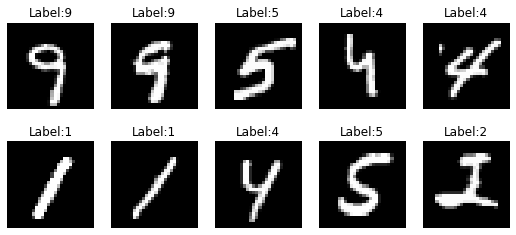

In [ ]:
plot_data(train_data.data, train_data.targets.numpy())

#### Define the model

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)                          
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected layer
        self.fc = nn.Linear(64 * 7 * 7, 128)
        # output layer 10 classes
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) #activation
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        # flatten the output for FC layer
        x = x.view(x.size(0), -1)       
        x = self.fc(x)
        output = self.out(x)
        return output

In [19]:
# Build the model object and put on the device
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=3136, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


#### Define Loss function

In [20]:
# Cross Entropy loss for multi-class classification
loss_func = nn.CrossEntropyLoss()   

#### Define optimizer

In [21]:
# Basic SGD optimizer with 0.01 learning rate
optimizer = optim.SGD(model.parameters(), lr = 0.01)

#### Train the model

Helper function for training/testing

In [22]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):
      
      # clear gradients for this training step   
      optimizer.zero_grad()           

      # Put data on devices
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients 
      loss.backward()

      # Apply gradients             
      optimizer.step()                
      
      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [23]:
def test(model, test_loader):
  # Eval mode
  model.eval()
  test_acc = 0
  correct = 0
  for i, (images, labels) in enumerate(test_loader):
    # Deactivate autograd engine (don't compute grads since we're not training)
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)
      output = model(images)

      # Calculate number of correct predictions
      _, preds = torch.max(output, dim=1)
      correct += (preds == labels).sum()

  test_acc = correct / len(test_loader.dataset)
  print('Test Accuracy: {:.4f}'.format(test_acc*100))

  # Plot the images with predicted labels
  plot_data(images.data.cpu().numpy(), preds.data.cpu().numpy(), test_loader.dataset.classes)

Start training

In [24]:
num_epochs = 10  # iterations
train_losses, train_acc = train(num_epochs, model, train_loader, loss_func, optimizer)

Epoch 1/10, Loss: 0.0115, Accuracy: 64.0833
Epoch 2/10, Loss: 0.0031, Accuracy: 88.3017
Epoch 3/10, Loss: 0.0024, Accuracy: 90.9067
Epoch 4/10, Loss: 0.0020, Accuracy: 92.4367
Epoch 5/10, Loss: 0.0017, Accuracy: 93.6917
Epoch 6/10, Loss: 0.0014, Accuracy: 94.7500
Epoch 7/10, Loss: 0.0012, Accuracy: 95.4867
Epoch 8/10, Loss: 0.0010, Accuracy: 96.0600
Epoch 9/10, Loss: 0.0009, Accuracy: 96.4850
Epoch 10/10, Loss: 0.0009, Accuracy: 96.7750


Plot training plots

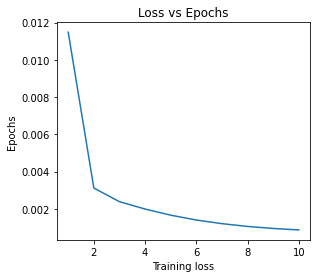

In [25]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
plt.show()

#### Evaluate the model

Test Accuracy: 97.1300


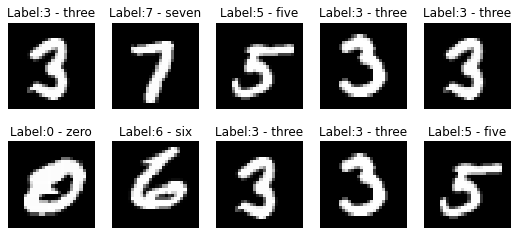

In [26]:
# Evaluate the model on testing data and plot predictions
test(model, test_loader)

### Exercises

Q 1: What is the ratio of parameters in single 5 x 5 kernel and equivalent stacked 3 x 3 kernels? Consider number of channels in input and output channels as C.

Q 2: How can you replace 7 x 7 convolution kernel using only 3 x 3 kernels? What would be ratio of parameters in this case? Consider number of channels in input and output channels as C.

## 3. CNN Visualization

Save the conv layers and their weights

In [27]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the conv layers in this list
# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [28]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([32, 1, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])


### Visualize the CONV layer filters

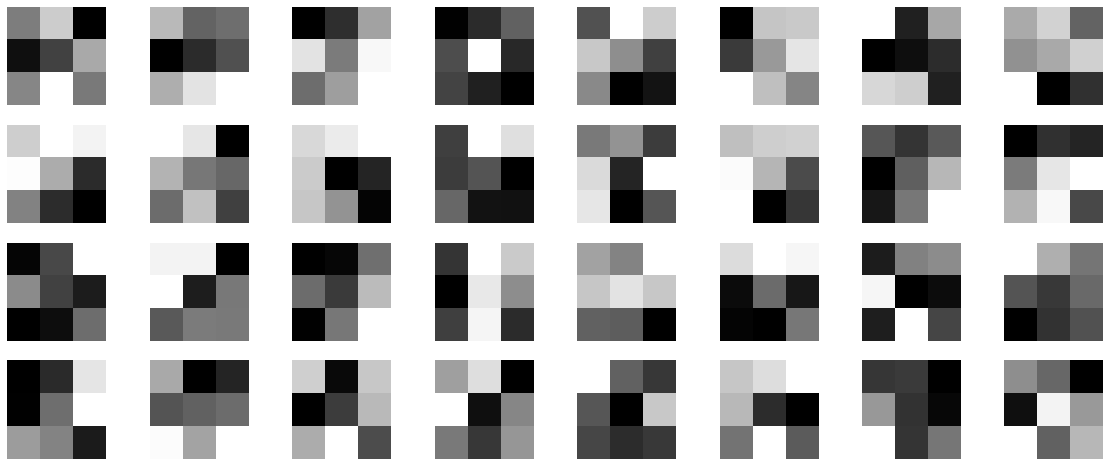

In [29]:
# Visualize the conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8)
    plt.imshow(filter[0, :, :].data.cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

### Visualize filter outputs on an image
Get an image from test dataset

2


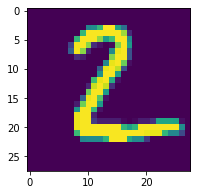

In [30]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images.data[1]
fig = plt.figure(figsize=(3,3))
plt.imshow(img.reshape((28,28)))
print(classes[labels.data[1]])

Forward pass the image through saved conv layers

In [31]:
results = [conv_layers[0](img.to(device))]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

Visualize features from each layer 

Layer output size: torch.Size([32, 28, 28])
Layer 0 feature maps...


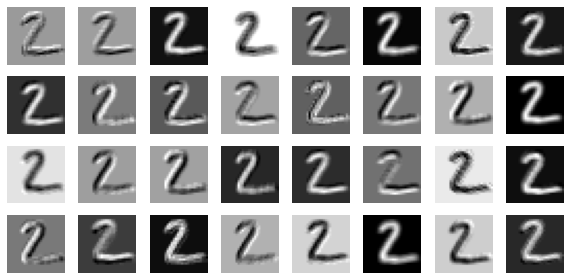

Layer output size: torch.Size([64, 28, 28])
Layer 1 feature maps...


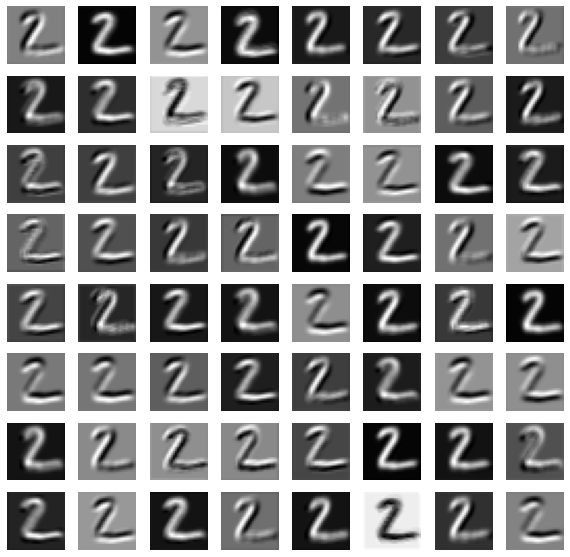

In [32]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(10, 10))
    layer_viz = outputs[num_layer][:, :, :]
    layer_viz = layer_viz.data
    print('Layer output size:', layer_viz.size())
    for i, filter in enumerate(layer_viz):
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu().numpy(), cmap='gray')
        plt.axis("off")
    print(f"Layer {num_layer} feature maps...")
    plt.show()
    plt.close()

## 4. Autoencoders


Autoencoders consists of an encoder network, which takes the input data and encodes it to fit into the latent space. These networks are trained in an unsupervised way to attempt to copy inputs to output. Because neural networks are capable of learning nonlinear relationships, this can be thought of as a more powerful (nonlinear) generalization of PCA. Whereas PCA attempts to discover a lower dimensional hyperplane which describes the original data, autoencoders are capable of learning nonlinear manifolds (a manifold is defined in simple terms as a continuous, non-intersecting surface). The difference between these two approaches is visualized below.

<img src='https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-8.52.21-AM.png' height=370/>

Convolutional layers can be incorporated in the encoder and decoders to learn important features from the image data (3D vectors) instead of flattened vectors (linear AE). The input image is downsampled to give a latent representation of smaller dimensions and force the autoencoder to learn a compressed version of the images. Then, it is upsampled back to reconstruct the input. Convolutional AE can be used for noise reduction where it learns to reconstruct a cleaner version of the image. The reconstructed image is compared to the original (without noise) image to compute the reconstruction loss. This way, the AE learns more robust features from image data.

<img src='https://lilianweng.github.io/lil-log/assets/images/denoising-autoencoder-architecture.png' height=400px width=900px/>

### Noise reduction using Convolutional Autoencoder
We will perform noise reduction similar to above figure on Fashion-MNIST dataset from Pytorch. We will add noise to the images for the network input and take targets as the original images.

In [33]:
# Import packages
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np


In [34]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#### Load Fashion-MNIST data
We will use the [Fashion-MNIST dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) from torchvision Pytorch and setup the train and test dataloaders in an usual manner.

In [36]:
batch_size_train = 128
batch_size_test = 128

# Images in torchvision datasets are PIL Images in range [0,1] so we need
# 'ToTensor' transform to convert them into tensors
train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [37]:
# Helper function to plot data
def plot_data(images, labels, classes=None):
  figure = plt.figure(figsize=(9, 4))
  cols, rows = 5, 2
  sample_idx = 0
  for i in range(1, cols * rows + 1):
      img, label = images[sample_idx], labels[sample_idx]
      sample_idx += 1
      figure.add_subplot(rows, cols, i)
      if classes is not None:
        label = classes[label]
      plt.title('Label:' +str(label))
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
      
  plt.show()

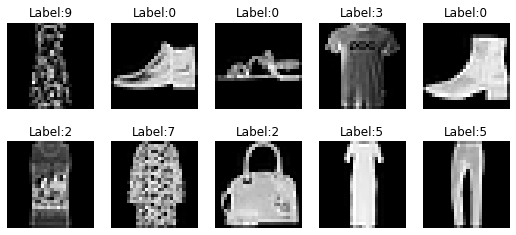

In [38]:
for i, sample in enumerate(train_loader):
  images, labels = sample
  plot_data(images, train_data.targets.numpy())
  break

#### Define the Autoencoder model
We stack up all our layers to perform encoding first with ReLU activation function. We also have the pooling layer after each convolutional layer. We thus obtain the latent space representation. Further, the decoding of the latent space representation takes place. Again all the ConvTranspose2d() go through the ReLU activation function. [ConvTranspose2d()](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) implements the reverse operation of Conv2d layer i.e reverse of convolution operation. The final decoding layer is coupled with the sigmoid activation function.

In [39]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoder
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))
        return x

In [40]:
# Build the model object and put on the device
model = Autoencoder().to(device)
print(model)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


#### Define Loss function

In [41]:
# Reconstuction loss (to compare original and reconstructed image)
loss_func = nn.MSELoss() # mean squared error loss

#### Define optimizer

In [42]:
# Basic SGD optimizer with 0.01 learning rate
optimizer = optim.SGD(model.parameters(), lr = 0.01)

#### Train the model
Function to add Gaussian noise to the image

In [43]:
def add_noise(image, mean=0., std=0.2):
  return image + torch.randn(image.size()) * std + mean

Helper function for training/testing

In [44]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, _) in enumerate(train_loader):
      
      # clear gradients for this training step   
      optimizer.zero_grad()    

      # Add noise to image
      noisy_images = add_noise(images)


      # Put data on devices
      images = images.to(device)
      noisy_images = noisy_images.to(device)

      # Forward pass with noisy data
      output = model(noisy_images)

      # Calculate loss with reconstructed images and original images
      loss = loss_func(output, images)

      # Backpropagation, compute gradients 
      loss.backward()

      # Apply gradients             
      optimizer.step()                
      
      # Running loss
      running_loss += loss.item()

      epoch_loss = running_loss / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    print ('Epoch {}/{}, Loss: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss))

  return train_losses

In [45]:
def test(model, test_loader):
  # Eval mode
  model.eval()
  test_acc = 0
  correct = 0
  for i, (images, labels) in enumerate(test_loader):
    # Deactivate autograd engine (don't compute grads since we're not training)
    with torch.no_grad():
      # Add noise to image
      noisy_images = add_noise(images)
      # Put data on devices
      images = images.to(device)
      noisy_images = noisy_images.to(device)

      # Forward pass
      output = model(noisy_images)
    break

  # Plot the noisy and corresponding reconstructed images
  plot_data(noisy_images.data.cpu().numpy(), labels.numpy(), test_loader.dataset.classes)
  plot_data(images.data.cpu().numpy(), labels.numpy(), test_loader.dataset.classes)

Start training

In [46]:
num_epochs = 5  # iterations
train_losses = train(num_epochs, model, train_loader, loss_func, optimizer)

Epoch 1/5, Loss: 0.0011
Epoch 2/5, Loss: 0.0010
Epoch 3/5, Loss: 0.0010
Epoch 4/5, Loss: 0.0010
Epoch 5/5, Loss: 0.0010


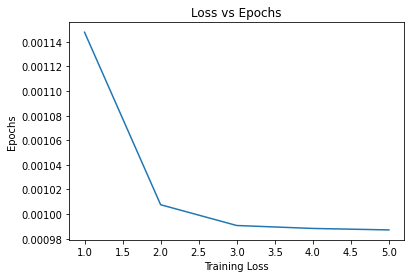

In [47]:
plt.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training Loss')
plt.ylabel('Epochs')
plt.title('Loss vs Epochs')
plt.show()

#### Evaluate the model

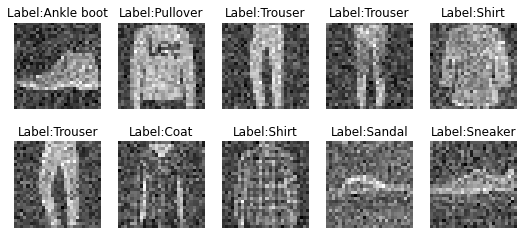

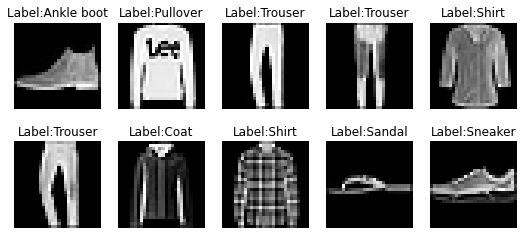

In [48]:
# Evaluate the model on testing data and plot predictions
test(model, test_loader)

As you can observe, the network learns to remove noise from the images and produce a cleaner version. Now, the encoder of the network which has already learnt important features from the dataset can be further used to perform classification.

### Exercises

Q: List a few practical applications of convolutional autoencoders.

Q: What change do we need to make for the autoencoder to reduce into PCA?

## References and Additional Resources:

*   [Training a classifier tutorial - Pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-an-image-classifier)
*   [Visualizing Filters and Feature Maps in Convolutional Neural Networks using PyTorch](https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/)
*   [ConvNetJS CIFAR10 Demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html)
*   [Autoencoder Neural Network: Application to Image Denoising](https://debuggercafe.com/autoencoder-neural-network-application-to-image-denoising/)
*   [Deep inside: Autoencoders - Medium Article](https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f)
*   [Denoising autoencoder for CIFAR10](https://codahead.com/blog/a-denoising-autoencoder-for-cifar-datasets)
*   [Autoencoders: Overview of Research and Applications](https://towardsdatascience.com/autoencoders-overview-of-research-and-applications-86135f7c0d35)
*   [AutoEncoders](https://www.jeremyjordan.me/autoencoders/)


